In [1]:
from src.datasets.crack_loader import CrackLoader
from torchvision import models
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utils import set_seed
import os
from torchvision import datasets, transforms
from src.nets.lenet import LeNet5
import seaborn as sns
from src.nets.swag import SWAG
import torch
from sklearn.calibration import calibration_curve

DATA_DIR = './data/crack'

set_seed(0)

In [95]:
def compute_uncertainties(probs, eps = 1e-12):
    # T: num MC passes
    # B: batch size
    # C: num classes

    T = probs.shape[0]
    probs = np.clip(probs, eps, 1 - eps)

    probs_mean = np.mean(probs, axis=0) # (B, C) 
    
    total_unc = -np.sum(probs_mean * np.log(probs_mean + eps), axis=1) # (B,) 
    ale_unc = np.mean(-np.sum(probs * np.log(probs + eps), axis=2), axis=0) # (B,)
    epi_unc = total_unc - ale_unc

    return total_unc, ale_unc, epi_unc

def total_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # TU = H(p_mean(y)), p_mean(y): average predictive probabilities over M models

    pmean = np.mean(out_probs, axis=0) # N x 2
    return -np.sum(pmean * np.log(pmean + eps), axis=1) # N

def aleatoric_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # AU = mean(H(p_m(y))), p_m(y): predictive probabilities for model m

    entropy_pm = -np.sum(out_probs * np.log(out_probs + eps), axis=-1) # M x N
    return np.mean(entropy_pm, axis=0) # N

def thresholded_accuracy(output_probs):
    output_probs_max_val = np.max(output_probs, axis=-1)  # M x N
    output_probs_max_class = np.argmax(output_probs, axis=-1)  # M x N
    
    tr = np.linspace(0, 1, 10)
    M, N, _ = output_probs.shape
    accuracies = np.zeros((len(tr), M))
    num_labels = np.zeros((len(tr), M))
    
    for i, threshold in enumerate(tr):
        for m in range(M):
            # Get boolean mask for samples with probability > threshold
            mask = output_probs_max_val[m] < threshold  # N 
    
            # Mask predictions
            valid_preds = output_probs_max_class[m][mask] 
            valid_labels = true_labels[mask]
    
            # Compute accuracy for valid predictions
            if len(valid_labels) > 0:
                accuracies[i, m] = np.mean(valid_preds == valid_labels)
            else:
                accuracies[i, m] = np.nan
            num_labels[i, m] = len(valid_labels)
    
    accuracies_avg_models = np.mean(accuracies, axis=1)
    num_labels_avg_models = np.mean(num_labels, axis=1)
    
    sns.lineplot(x=tr, y=accuracies_avg_models, marker='o', label='Accuracy')
    sns.lineplot(x=tr, y=tr, marker='o', label='Calibrated model')
    plt.xlabel(r'Confidence threshold $\tau$')
    plt.ylabel(r'Accuracy on examples p(y|x) >= $\tau$')
    plt.grid(True)
    plt.show()

def nll(probabilities, labels, eps=1e-6):
    score = -np.log(probabilities+eps)[range(labels.shape[0]), labels].mean()
    return score
    
def accuracy(probabilities, labels):
    predicted = np.argmax(probabilities, axis=-1)
    return np.sum(labels == predicted) / len(labels)

def brier_score(probabilities, labels):
    num_classes = probabilities.shape[1]

    targets_one_hot = np.zeros_like(probabilities)
    targets_one_hot[np.arange(labels.shape[0]), labels] = 1.

    squared_diff = (targets_one_hot - probabilities) ** 2
    score = np.mean(np.sum(squared_diff, axis=1) / num_classes)

    return score
    
def compute_ece(probs, labels, num_bins=10):
    predictions = np.argmax(probs, axis=-1)
    ece = 0.0
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    
    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (predictions > bin_lower) & (predictions <= bin_upper)
        bin_size = np.sum(in_bin)
        
        if bin_size > 0:
            avg_confidence = np.mean(predictions[in_bin])
            avg_accuracy = np.mean(labels[in_bin])
            ece += (bin_size / len(predictions)) * np.abs(avg_confidence - avg_accuracy)
            
    return ece.item()

def plot_calibration(probs, labels, n_bins=10):
    confidences = np.max(probs, axis=-1)
    predictions = np.argmax(probs, axis=-1)

    fraction_of_positives, mean_confidences = calibration_curve(
        (predictions == labels), confidences, n_bins=n_bins
    )
    
    plt.plot(mean_confidences, fraction_of_positives, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.title('Reliability Diagram')
    plt.xlabel('Confidence')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.show()

def plot_images_uncertainty(probs, tu, au, eu, max_unc=True):
    if max_unc:
        tu_indices = np.argsort(tu)[-4:]
        tu_values = tu[tu_indices]
    else:
        tu_indices = np.argsort(tu)[:4]
        tu_values = tu[tu_indices]
        
    predicted_classes = np.argmax(probs, axis=-1)
    class_0_count = np.sum(predicted_classes == 0, axis=0) 
    class_1_count = np.sum(predicted_classes == 1, axis=0)
    fig, axes = plt.subplots(1, len(tu_indices), figsize=(10, 3))
    for ax, idx in zip(axes, tu_indices):
        image, label = val_dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()
        ax.imshow(image_np)
        ax.axis('off')
        ax.set_title(f"({idx})\nLabel: {label}\ntu = {tu[idx]:.3f}\nau = {au[idx]:.3f}\neu = {eu[idx]:.3f}\nPredicted 0/1: {class_0_count[idx]}/{class_1_count[idx]}")
    plt.tight_layout()
    plt.show()

## Load dataset
We start by constructing a *dataloader* for the dataset of interest. The labels will be:
- $0$: cracked
- $1$: uncracked
We proceed with a quick visualization for the data of interest

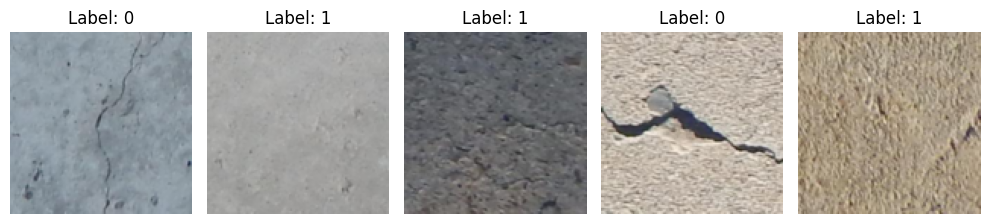

In [78]:
results = np.load('./experiments/results/resnet18_vi.npz')
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])
train_image_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
train_dataset = torch.utils.data.Subset(train_image_dataset, results['train_indices'])
val_dataset = torch.utils.data.Subset(train_image_dataset, results['val_indices'])
indices = [0, 10, 60, 80, 100]
fig, axes = plt.subplots(1, len(indices), figsize=(10, 5))
for ax, idx in zip(axes, indices):
    image, label = val_dataset[idx]
    image_np = image.permute(1, 2, 0).numpy()
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_title(f"Label: {label}")
        
plt.tight_layout()
plt.show()

Accuracy: 85.905%
MNLL: 0.764


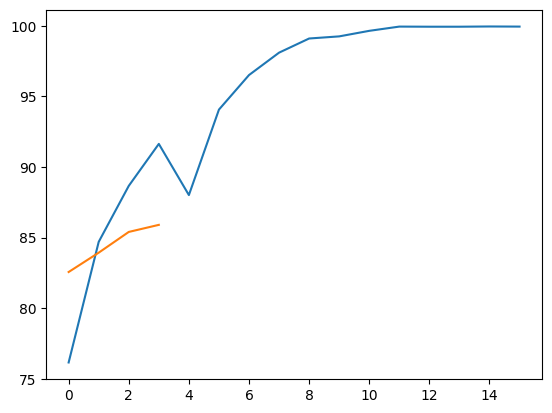

In [90]:
model = torch.load('./experiments/models/resnet18_optim.pt', weights_only=False)
results = np.load('./experiments/results/resnet18_optim.npz')
sns.lineplot(results['train_accuracy_progress'])
sns.lineplot(results['valid_accuracy_progress'])
np.argmax(results['predictions'], axis=-1)
acc = accuracy(results['predictions'], results['true_labels'])
neg_loglik = nll(results['predictions'], results['true_labels'])
print(f"Accuracy: {acc*100:.3f}%")
print(f"MNLL: {neg_loglik:.3f}")

## Ensamble method: Monte Carlo dropout

Accuracy (average over all models): 85.942%
MNLL (average over all models): 0.346
TU = 0.2794 +- 0.2373
AU = 0.2488 +- 0.2102
EU = 0.0307 +- 0.0416
ECE= 0.0885


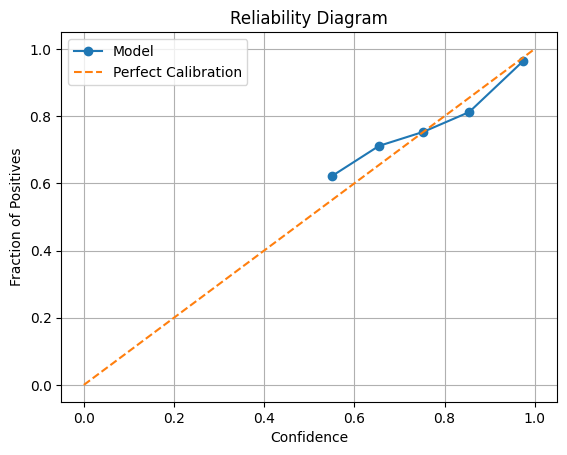

In [93]:
model = torch.load('./experiments/models/resnet18_mcdropout.pt', weights_only=False, map_location=torch.device('cpu'))
results = np.load('./experiments/results/resnet18_mcdropout.npz')
output_probs = results['predictions']
true_labels = results['true_labels']
tu = total_uncertainty(output_probs)
au = aleatoric_uncertainty(output_probs)
eu = tu - au
ece = compute_ece(output_probs.mean(0), true_labels)
nll_models = [nll(output_probs[m], results['true_labels']) for m in range(output_probs.shape[0])]
acc_models = [accuracy(output_probs[m], results['true_labels']) for m in range(output_probs.shape[0])]
neg_loglik = np.mean(nll_models)
acc = np.mean(acc_models)
print(f"Accuracy (average over all models): {acc*100:.3f}%")
print(f"MNLL (average over all models): {neg_loglik:.3f}")
print("TU = {:.4f} +- {:.4f}".format(np.mean(tu), np.std(tu)))
print("AU = {:.4f} +- {:.4f}".format(np.mean(au), np.std(au)))
print("EU = {:.4f} +- {:.4f}".format(np.mean(eu), np.std(eu)))
print("ECE= {:.4f}".format(ece))
plot_calibration(output_probs.mean(0), true_labels)

Here are $4$ crack images for which the classifier is the most **unsure** about:

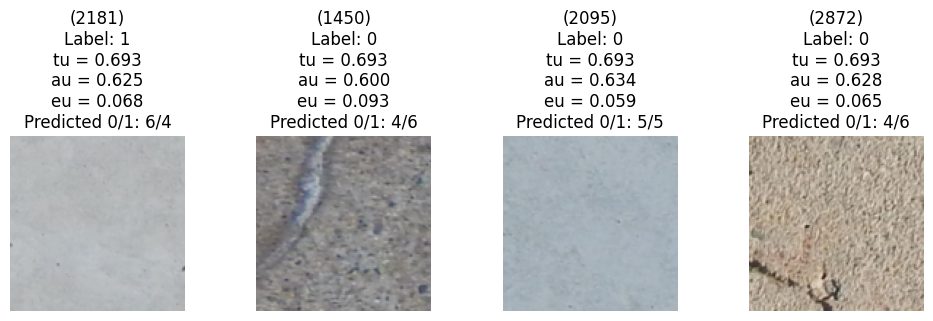

In [71]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=True)

Here are $4$ crack images for wich the classifier is the most **sure** about:

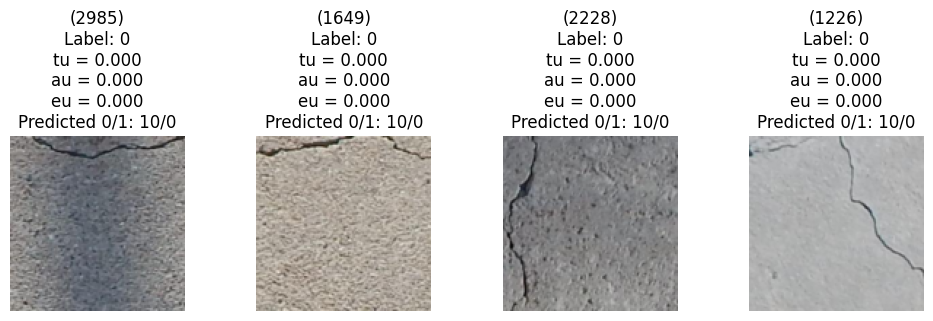

In [72]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=False)

## Approximate posterior: Variational Inference

Accuracy (average over all models): 50.650%
MNLL (average over all models): 1.122
TU = 0.5456 +- 0.0503
AU = 0.4510 +- 0.0705
EU = 0.0946 +- 0.0694
ECE= 0.0003


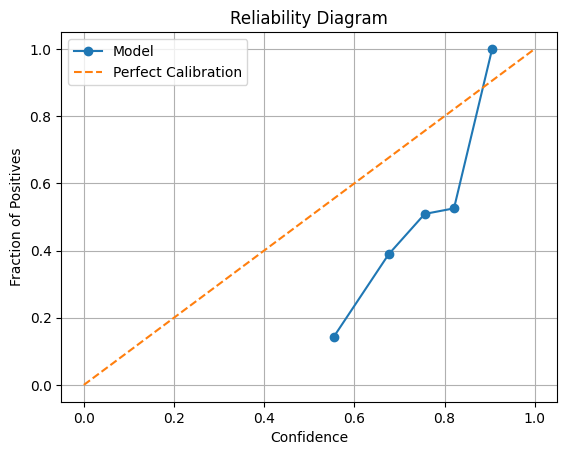

In [96]:
model = torch.load('./experiments/models/resnet18_vi.pt', weights_only=False, map_location=torch.device('cpu'))
results = np.load('./experiments/results/resnet18_vi.npz')
output_probs = results['predictions']
true_labels = results['true_labels']
tu = total_uncertainty(output_probs)
au = aleatoric_uncertainty(output_probs)
eu = tu - au
ece = compute_ece(output_probs.mean(0), true_labels)
nll_models = [nll(output_probs[m], results['true_labels']) for m in range(output_probs.shape[0])]
acc_models = [accuracy(output_probs[m], results['true_labels']) for m in range(output_probs.shape[0])]
neg_loglik = np.mean(nll_models)
acc = np.mean(acc_models)
print(f"Accuracy (average over all models): {acc*100:.3f}%")
print(f"MNLL (average over all models): {neg_loglik:.3f}")
print("TU = {:.4f} +- {:.4f}".format(np.mean(tu), np.std(tu)))
print("AU = {:.4f} +- {:.4f}".format(np.mean(au), np.std(au)))
print("EU = {:.4f} +- {:.4f}".format(np.mean(eu), np.std(eu)))
print("ECE= {:.4f}".format(ece))
plot_calibration(output_probs.mean(0), true_labels)

Here are $4$ crack images for which the classifier is the most **unsure** about:

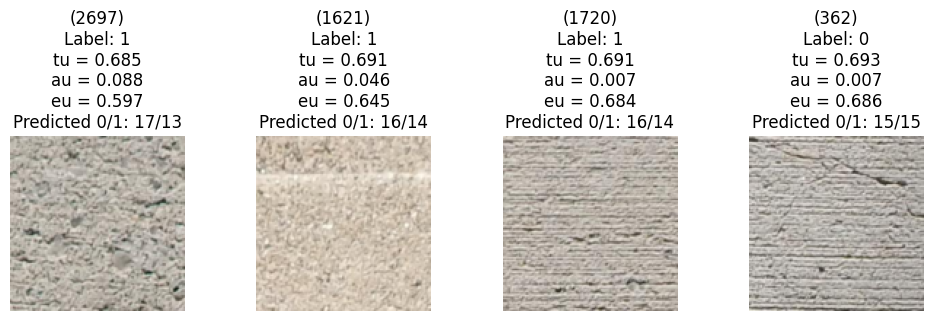

In [74]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=True)

Here are $4$ crack images for which the classifier is the most **sure** about:

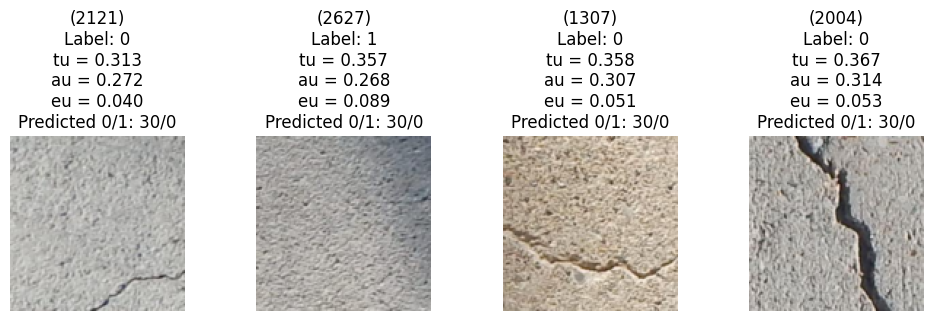

In [75]:
plot_images_uncertainty(output_probs, tu, au, eu, max_unc=False)

In [97]:
# TODO: run again all models to collect 30 samples and for 30 epochs
# Comment on the images for which the classifier is both sure and they are wrong and maybe vice versa
# Run optim with validation for each epoch
# Write something about how MC dropout and VI work
# Write distribution of class labels at the beginning
# For Models B and C, study the sensitivity of the uncertainties in point (c) above wrt to the choice of the prior. ???